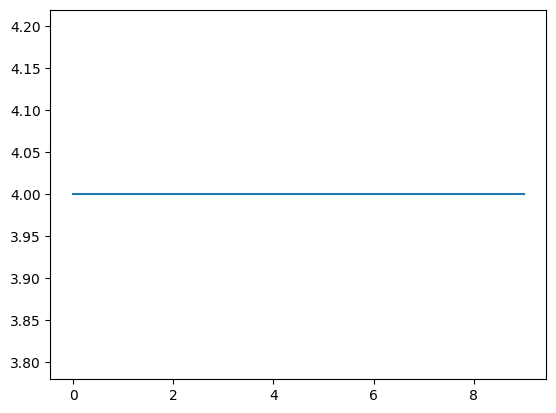

In [1]:
import matplotlib.pyplot as plt

x = [i for i in range(10)]
y = [4] * 10
plt.plot(x, y)


plt.show()

In [2]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
from collections import Counter
import random
from torchvision.transforms import RandomAffine, RandomErasing
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset
import random

class SingleFolderTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('L')  # 假设是灰度图像
        if self.transform:
            image = self.transform(image)
        # 所有图像都被视为属于同一个类别，例如类别0
        label = 0
        return image, label
    
# 数据预处理
# 对于训练集，我们使用数据增强
mean_gray = 0.5  # 灰度图的平均值，这里假设为0.5，实际应根据数据调整
std_gray = 0.5   # 灰度图的标准差，这里假设为0.5，实际应根据数据调整
size = 40       # 裁剪尺寸
degrees = 10    # 最大旋转角度
erase_prob = 0.7 # 随机擦除的概率
train_transform = transforms.Compose([
    # 灰度化
    transforms.Grayscale(num_output_channels=1),
    
    # 数据增强部分
    transforms.RandomResizedCrop(size=(size, size), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=degrees, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=degrees),
    
    # 五次裁剪与镜像扩展
    transforms.FiveCrop(size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda tensors: torch.cat([tensors, tensors.flip(dims=[2])], dim=0)),  # 水平垂直镜像
    
#     # 标准化
    transforms.Normalize(mean=[mean_gray], std=[std_gray]),
    
#     # 随机擦除
    transforms.RandomErasing(p=erase_prob),
    
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize([0.5], [0.5])  # 假设数据已经中心化，且范围在[-1, 1]之间
])

# 对于验证集和测试集，我们不使用数据增强，只进行必要的预处理
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 假设使用[-1, 1]范围
])

batch_size = 128
# 数据路径
train_dir = r"C:/Users/ymh33/Desktop/MachineLearning/fer_data/fer_data/train"
test_dir = r"C:/Users/ymh33/Desktop/MachineLearning/fer_data/fer_data/test"

# 加载训练数据
original_dataset = ImageFolder(root=train_dir, transform=train_transform)
original_loader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False)
# 分割数据集
total_size = len(original_dataset)
train_size = int(0.95 * total_size)  # 95%用于训练
val_size = total_size - train_size  # 5%用于验证

# 计算每个类别的样本数量
class_counts = Counter(original_dataset.targets)
train_counts = {cls: int(0.9 * count) for cls, count in class_counts.items()}
val_counts = {cls: count - train_counts[cls] for cls, count in class_counts.items()}

# 创建训练集和验证集的索引列表
train_indices = []
val_indices = []
for cls, count in class_counts.items():
    # 获取类别cls的所有索引
    cls_indices = [i for i, target in enumerate(original_dataset.targets) if target == cls]
    # 随机打乱索引
    random.shuffle(cls_indices)
    # 分割索引到训练集和验证集
    train_indices.extend(cls_indices[:train_counts[cls]])
    val_indices.extend(cls_indices[train_counts[cls]:])

# 使用分层抽样分割数据集
train_dataset = Subset(original_dataset, train_indices)
val_dataset = Subset(original_dataset, val_indices)
print(f"len train {len(train_dataset)}")
print(f"len val {len(val_dataset)}")

# 创建训练和验证数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 为验证集设置新的transform
val_dataset.dataset.transform = val_test_transform
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 加载测试数据
test_dataset = SingleFolderTestDataset(root_dir=test_dir, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 打印数据集信息
print(f"训练集类别: {original_dataset.class_to_idx}")

# 可视化数据
def visualize_data(dataset, index):
    image, label = dataset[index]
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {original_dataset.classes[label]}")
    plt.show()

# 可视化训练集中的一个样本
# visualize_data(train_dataset, 10000)

# 获取原始数据集的标签
original_targets = original_dataset.targets

# 打印训练集中的类别及其数量
train_class_counts = Counter(original_targets[index] for index in train_dataset.indices)
print("训练集类别数量:")
for cls, count in train_class_counts.items():
    print(f"类别 {cls}: {count}")

# 打印验证集中的类别及其数量
val_class_counts = Counter(original_targets[index] for index in val_dataset.indices)
print("\n验证集类别数量:")
for cls, count in val_class_counts.items():
    print(f"类别 {cls}: {count}")

len train 25444
len val 2831
训练集类别: {'Angry': 0, 'Fear': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}
训练集类别数量:
类别 0: 3566
类别 1: 3687
类别 2: 6472
类别 3: 4463
类别 4: 4375
类别 5: 2881

验证集类别数量:
类别 0: 397
类别 1: 410
类别 2: 720
类别 3: 496
类别 4: 487
类别 5: 321


In [3]:
import torch
import torchvision.models as models
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.nn import Conv2d
import torch.nn as nn

# 加载ResNet18模型
model = models.resnet18(pretrained=True)

# 修改模型
model.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 6)

# 判断GPU是否可用，并将模型迁移至GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1, reduction='mean')

# 配置Adam优化器
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adam优化器设置，初始学习率设为0.001

C:\Users\ymh33\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ymh33\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# 初始化列表来存储损失和准确率
train_losses = []
val_losses = []
val_accuracies = []
num_epochs = 100

# 初始化最佳准确率和最佳模型路径
best_acc = 0.0
best_model_path = "best_model.pth"
# best_model_path = "model_epoch_24.pth"

In [ ]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm


# model_epoch_24.pth
model.load_state_dict(torch.load(best_model_path))
model.to(device)

# 训练循环
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
#         print(labels)
        optimizer.zero_grad()
        outputs = model(images)
#         print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    # 每个epoch的平均训练损失
    avg_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # 验证损失和准确率
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    acc = 100 * correct / total
    val_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {acc:.2f}%")

    # 每隔3个epoch保存模型
    if (epoch + 1) % 3 == 0:
        torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")

    # 更新最优模型
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated at epoch {epoch+1} with accuracy {best_acc:.2f}%")

100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [03:57<00:00,  1.19s/it]


Epoch 1/100, Training Loss: 0.5557


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.82it/s]


Epoch 1/100, Validation Loss: 0.6952, Validation Accuracy: 87.74%


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [04:32<00:00,  1.37s/it]


Epoch 2/100, Training Loss: 0.5479


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.78it/s]


Epoch 2/100, Validation Loss: 0.6828, Validation Accuracy: 88.24%


 75%|████████████████████████████████████████████████████████████▎                   | 150/199 [03:31<00:57,  1.18s/it]

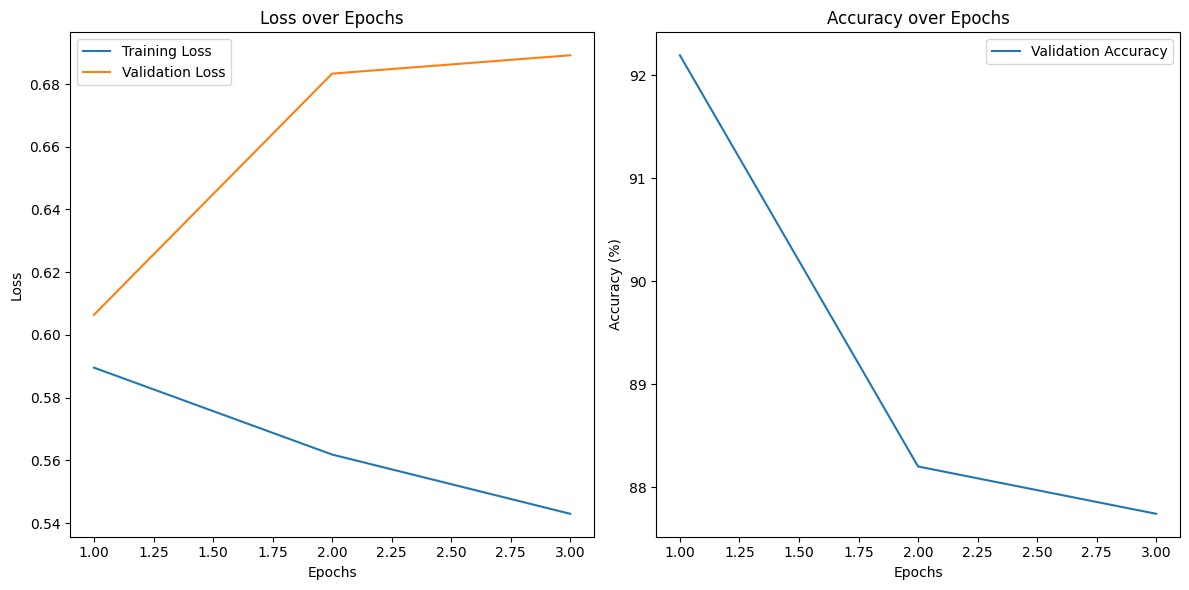

In [6]:
# 绘制损失和准确率的变化曲线
plt.figure(figsize=(12, 6))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# 加载最优模型
# best_model_path = "model_epoch_24.pth"
best_model_path = "best_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.84it/s]


Epoch 4/100, Validation Loss: 0.6079, Validation Accuracy: 92.19%


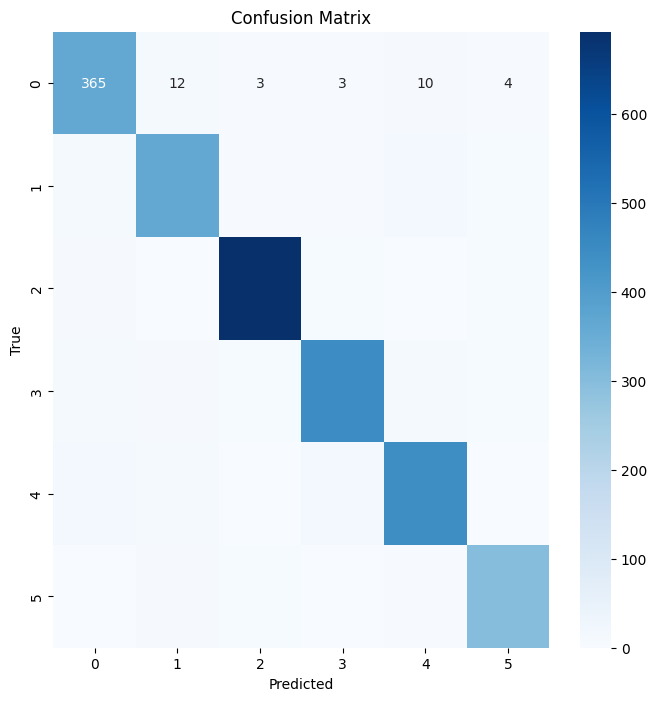

[[365  12   3   3  10   4]
 [ 13 364   4   4  17   8]
 [  9   2 693   8   2   6]
 [ 13  10   6 446  13   8]
 [ 15  12   1  15 442   2]
 [  0  10   7   0   4 300]]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from PIL import Image
import shutil
from tqdm import tqdm

# 初始化空列表以存储预测结果和真实标签
predictions = []
true_labels = []
num_classes = 6
# 在验证集上计算预测结果
model.eval()
val_loss = 0.0
correct = 0

total = 0
label_dict = {
0: "生气",
1: "恐惧",
2: "高兴",
3: "自然",
4: "伤心",
5: "惊讶"
}

# 可视化数据
def visualize_data(dataset, index):
    image, label = dataset[index]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {original_dataset.classes[label]}")
    plt.show()
    
folder_path = "confusion_matrix_images"
if os.path.exists(folder_path):
    # 使用shutil模块的rmtree函数删除文件夹及其内容
    shutil.rmtree(folder_path)
    print("已删除")

# for i in range(num_classes):
#     for j in range(num_classes):
#         folder_name = f"{i}_{j}"
#         folder_path = os.path.join("confusion_matrix_images", folder_name)
#         if not os.path.exists(folder_path):
#             os.makedirs(folder_path)
cnt = 0      
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 收集预测结果和真实标签
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
#         for label, pred in zip(labels, predicted):
#             label, pred = label.item(), pred.item()
# #             print(f"pred:{pred}\nlabel:{label}")
# #             print(f"type {type(pred)}  {type(label)}")
#             image, true_label = original_dataset[cnt]
#             folder_path = os.path.join("confusion_matrix_images", f"{label}_{pred}")
#             image_path = os.path.join(folder_path, str(cnt))
#             image_array = image.cpu().numpy()
#             plt.rcParams["font.sans-serif"] = ["SimHei"]
#             plt.figure()
#             plt.title(f"真实/预测 {label_dict[label]} / {label_dict[pred]}")
#             plt.imshow(image_array.squeeze(), cmap='gray')
#             plt.savefig(image_path)
#             plt.close()
# #             plt.show()
#             cnt += 1

# 计算平均验证损失和准确率
avg_val_loss = val_loss / len(val_loader)
val_losses.append(avg_val_loss)
acc = 100 * correct / total
val_accuracies.append(acc)
epoch = 3
print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {acc:.2f}%")

# 计算混淆矩阵
confusion_mat = confusion_matrix(true_labels, predictions)
# 绘制混淆矩阵
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(confusion_mat)

In [9]:
# 在测试集上评估模型
from PIL import Image
from tqdm import tqdm
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # 直接使用数字标签
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.cpu().numpy())

# 保存预测结果到result.txt
with open('result.txt', 'w') as f:
    for label in predictions:
        f.write(f"{label}\n")

print("预测结果已保存到result.txt文件中。")

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:21<00:00,  2.66it/s]

预测结果已保存到result.txt文件中。


In [10]:
# 定义新的映射关系
idx_to_class = {0: 0, 1: 1, 2: 2, 3: 5, 4: 3, 5: 4}

# 读取result.txt中的数字，并进行映射转换
with open('result.txt', 'r') as f:
    original_labels = [int(line.strip()) for line in f.readlines()]

# 进行映射转换
mapped_labels = [idx_to_class[label] for label in original_labels]

# 保存转换后的结果到新的文件中
with open('mapped_result.txt', 'w') as f:
    for label in mapped_labels:
        f.write(f"{label}\n")

print("映射转换后的结果已保存到mapped_result.txt文件中。")

映射转换后的结果已保存到mapped_result.txt文件中。


In [11]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv(r'C:/Users/ymh33/Desktop/MachineLearning/fer_data/fer_data/submission.csv')

# 读取mapped_result.txt文件
with open('mapped_result.txt', 'r') as file:
    mapped_results = file.read().splitlines()

# 确保mapped_results列表的长度足够长，以匹配CSV文件的行数
if len(mapped_results) < len(df):
    raise ValueError("The mapped_results list is shorter than the number of rows in the CSV file.")

# 替换CSV文件中的数字
df['Emotion'] = [mapped_results[i] for i in range(len(df))]

# 保存修改后的CSV文件
df.to_csv('C:/Users/ymh33/Desktop/MachineLearning/fer_data/fer_data/submission_modified.csv', index=False)